In [1]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"



MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME

# Engine

## TensorRTLLM

In [2]:
METHOD = "engine/tensorrtllm"
METHOD_EXPORTS = EXPORTS / METHOD

In [3]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/tensorrtllm


In [4]:
# tensorrtllm engine sizes
tensorrtllm_engines = [x/"engine" for x in METHOD_EXPORTS.iterdir() if x.is_dir()]

for engine in tensorrtllm_engines:
    # model_size := size of directory
    model_size = sum([x.stat().st_size for x in engine.glob("*")])
    print(f"{engine.parent.name} engine size: {model_size / (1024 ** 3):.2f} GiB")

int4_awq engine size: 3.42 GiB
gptq engine size: 3.60 GiB
int8 engine size: 6.53 GiB
base_f16 engine size: 12.56 GiB
sq0_8 engine size: 6.53 GiB


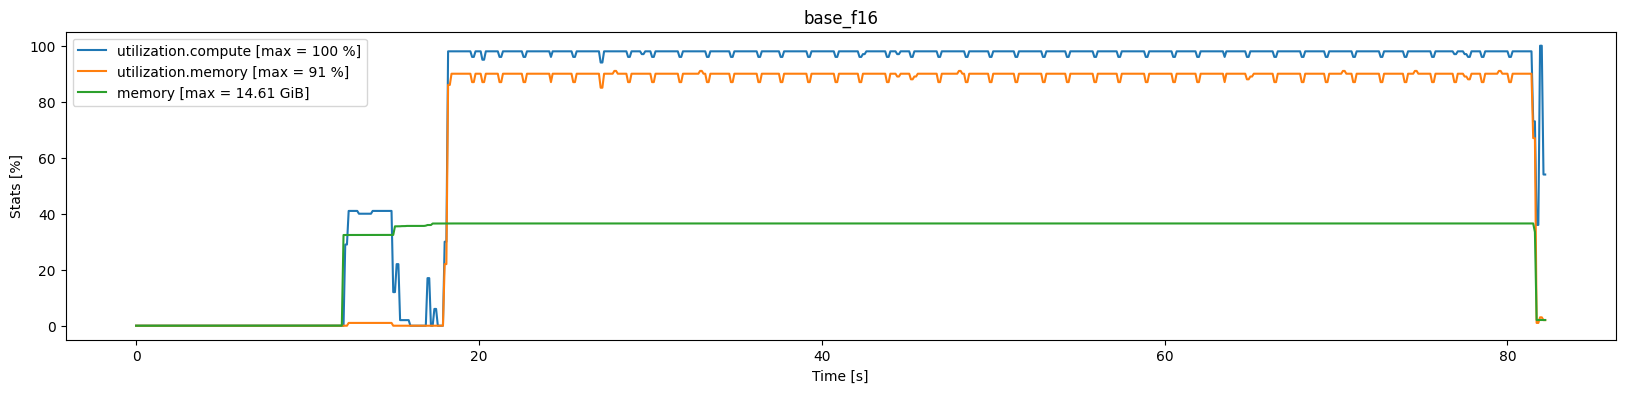

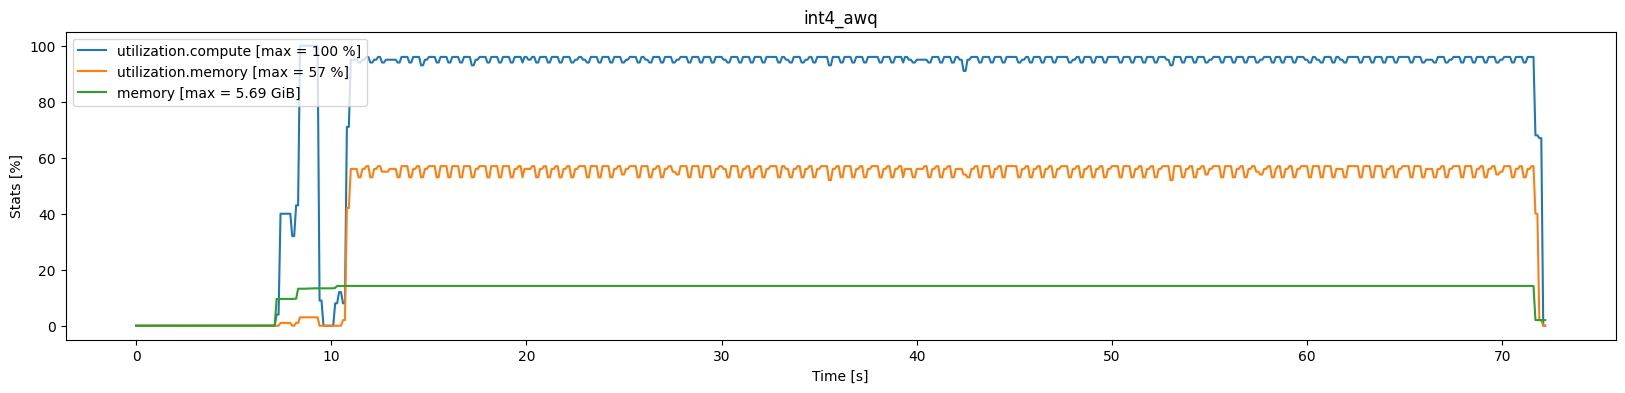

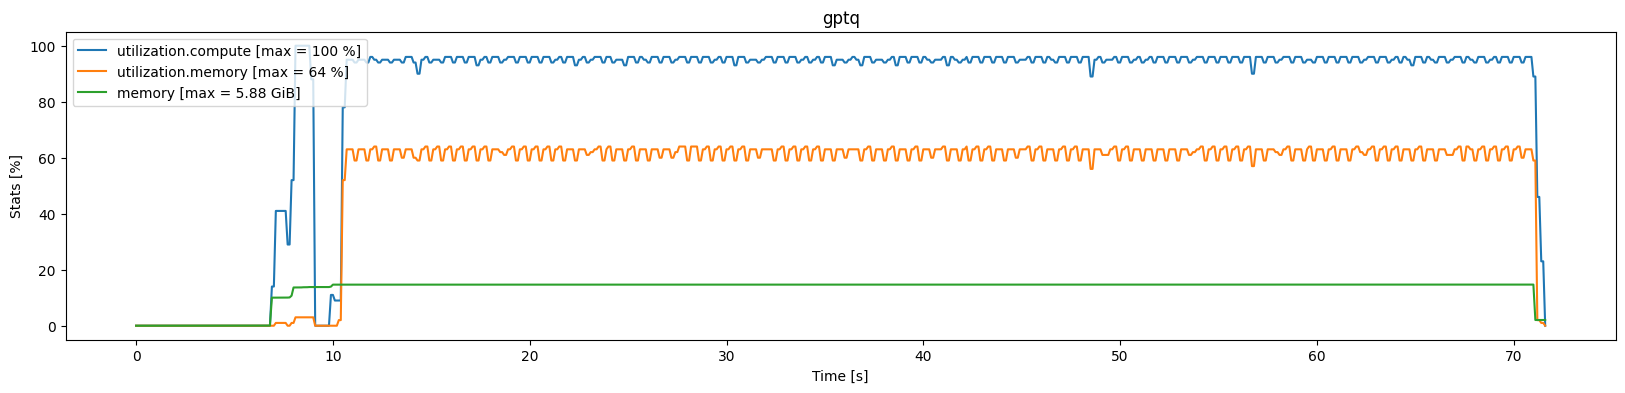

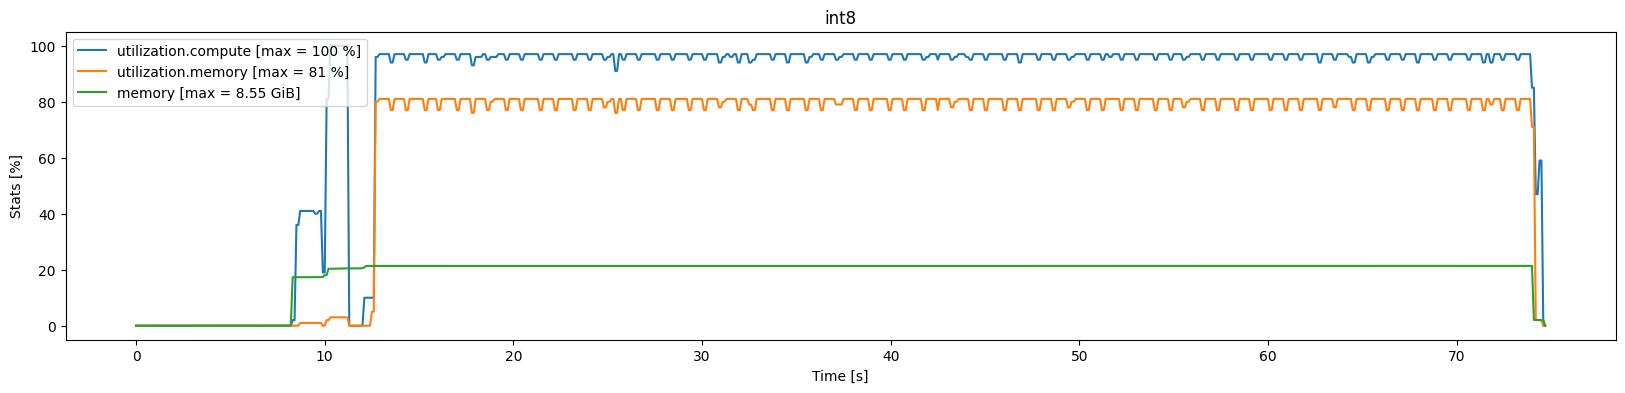

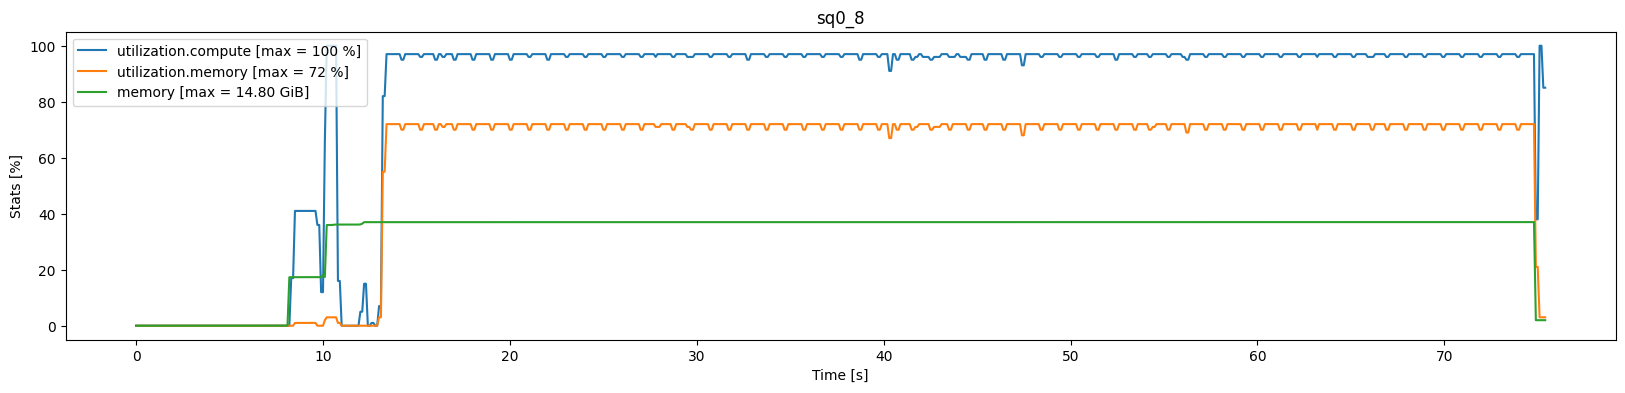

In [5]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)

    # if "squeeze" in csv.name:
    #     df = df[df.index % 10 == 0]

    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")


In [6]:
# benchmark logs
all_logs = list(METHOD_EXPORTS.glob("*.log"))

for log in all_logs:
    if not "bench" in log.name:
        continue

    print(f"{log.name.replace('_', ' ')[:-4]}")
    with open(log) as f:
        line = f.readlines()[-1]
    # split line by spaces and print in paris of 2
    line = line.split(' ')[1:]
    stats = {}
    for i in range(0, len(line), 2):
        stats[line[i]] = line[i+1]
    print(f"tokens_per_sec: {stats['tokens_per_sec']}")
    print(f"gpu_peak_mem(gb): {stats['gpu_peak_mem(gb)']}\n")
    
    


benchmark int8
tokens_per_sec: 143.57
gpu_peak_mem(gb): 9.12

benchmark gptq
tokens_per_sec: 202.16
gpu_peak_mem(gb): 6.45

benchmark base f16
tokens_per_sec: 83.43
gpu_peak_mem(gb): 15.18

benchmark int4 awq
tokens_per_sec: 194.86
gpu_peak_mem(gb): 6.26

benchmark sq0 8
tokens_per_sec: 129.06
gpu_peak_mem(gb): 15.37

